In [8]:
import glob
import lxml.etree as ET
import pandas as pd
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from collections import namedtuple
import csv
Date = namedtuple("Date", ["birth", "death"])
dates = {}
NomsFr = {}

# On ouvre le fichier qui contient les dates
with open("../../data/raw/datation.tsv") as f:
    reader = csv.DictReader(f, delimiter="\t")
    # Pour chacune des URN, on remplit avec le textgroup le dictionnaire data
    for line in reader:
        urn = line["URN"]
        # Si on a une URN et que cette ligne ne doit pas être ignorée
        if urn and line["Ignore"] != "x":
            textgroup = urn.split(".")[0]
            if textgroup not in dates:
                if not line["Birth"].lstrip('-').isdigit():
                    print("Error at following line")
                    print(line)
                else:
                    dates[textgroup] = Date(int(line["Birth"]), int(line["Death"]))
        else:
            print(f"Ignored {line['Work title']} / {line['Nom FR']}")
            
        if line.get("Nom FR"):
            nom_fr = line['Nom FR']
            if textgroup not in NomsFr:
                NomsFr[textgroup] = nom_fr
            
all_dates = list([d for tup in dates.values() for d in tup])
Min_date, Max_date = min(all_dates), max(all_dates)

AdditionalDates = {
    "urn:cts:latinLit:stoa0170a": (250, ),
    "urn:cts:latinLit:phi1257": (117, ),
    "urn:cts:latinLit:stoa0241d": (841, ),
    "urn:cts:latinLit:stoa0365": (350, ),
    "urn:cts:latinLit:stoa0364": (800, )
}

Ignored None / Rémi d'Auxerre
Ignored None / Pseudo-Hilarius
Ignored None / Granius Licinianus
Ignored None / Celse
Ignored None / Celse
Ignored None / Claudius Marius Victor
Ignored None / Pierre le Diacre
Error at following line
{'S': '', 'Ignore': '', 'URN': 'urn:cts:latinLit:stoa0364.stoa001.digilibLT-lat1', 'Nom FR': '', 'Birth': '', 'Death': '', 'certainty': '', 'Citation level': '2', 'Name of citation level': 'book,chapter', 'Sources': '', 'Sources Pages': '', 'Notes': '', 'Nom ENG': 'Mythographus Vaticanus I', 'Work title': 'Mythographus Vaticanus I'}
Error at following line
{'S': '', 'Ignore': '', 'URN': 'urn:cts:latinLit:stoa0365.stoa002.digilibLT-lat1', 'Nom FR': '', 'Birth': '', 'Death': '', 'certainty': '', 'Citation level': '1', 'Name of citation level': 'chapter,paragraph', 'Sources': '', 'Sources Pages': '', 'Notes': '', 'Nom ENG': 'De Taxone (Recensio β)', 'Work title': 'De Physiognomonia liber'}
Ignored None / Cornelius Labeo
Error at following line
{'S': '', 'Ignore'

In [81]:
counts = defaultdict(Counter)
WORDS = [
    ("lasciv-", "contains(@lemma, 'lasciu')"),
    ("mollis & mollitia", "@lemma='mollis' or @lemma='mollitia'"),
    ("virginitas", "@lemma='uirginitas'"),
    ("purus & puritas", "@lemma='purus' or @lemma='puritas'"),
    ("impurus", "@lemma='impurus'"),
    ("libido", "@lemma='libido'"),
    ("voluptas", "@lemma='uoluptas'"),
    ("mentula", "@lemma='mentula'"),
    ("futuo", "@lemma='futuo'"),
    ("pedico", "@lemma='pedico'"),
    ("irrumo", "@lemma='irrumo'"),
    ("cunnus", "@lemma='cunnus'")
]
NS = {"t": "http://www.tei-c.org/ns/1.0"}

In [82]:
for file in glob.glob("/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/*.xml"):
    local_xml = ET.parse(file)
    urn = local_xml.xpath("//t:idno/text()", namespaces=NS)[0]
    textgroup = urn.split(".")[0]
    for title, xpath in WORDS:
        counts[textgroup][title] += len(local_xml.xpath(f"//t:w[{xpath}]", namespaces=NS))

In [108]:
Themes = {
    "Adjectifs et termes\n liés à la sexualité": ["lasciv-",
                "mollis & mollitia",
                "impurus",
                "libido",
                "voluptas"],
    "Adjectifs et termes\n liés à l'absence de sexualité": [
                "virginitas",
                "purus & puritas"
    ],
    "Obscénités": ["mentula",
                    "futuo",
                    "pedico",
                    "irrumo",
                    "cunnus"]
}
Themes = {
    lexeme: theme
    for theme, lexs in Themes.items()
    for lexeme in lexs
}

In [109]:
df = pd.DataFrame([
    {
        "Auteur": key,
        "Lemmes et lexèmes": word,
        "Fréquence": value,
        "Groupe lexical": Themes.get(word),
        "Année": dates.get(key, AdditionalDates.get(key, (-999,)))[0] // 50 * 50
    } 
    for key, wordcount in counts.items()
    for word, value in wordcount.items()
])

df = df[~ df.Auteur.isin(["urn:cts:latinLit:stoa0227b", "urn:cts:latinLit:stoa0359"])]

In [110]:
Key = "Groupe lexical"
df = df.groupby(["Année", Key])["Fréquence"].sum().reset_index()
df["Fréquence relative"] = df.apply(
    lambda x: x["Fréquence"] / df[df[Key] == x[Key]]["Fréquence"].sum(),
    axis = 1
)
df

,Année,Groupe lexical,Fréquence,Fréquence relative
0,-300,Adjectifs et termes\n liés à l'absence de sexu...,9,0.002716
1,-300,Adjectifs et termes\n liés à la sexualité,99,0.009679
2,-300,Obscénités,0,0.000000
3,-250,Adjectifs et termes\n liés à l'absence de sexu...,25,0.007544
4,-250,Adjectifs et termes\n liés à la sexualité,2,0.000196
...,...,...,...,...
64,800,Adjectifs et termes\n liés à la sexualité,15,0.001467
65,800,Obscénités,0,0.000000
66,900,Adjectifs et termes\n liés à l'absence de sexu...,2,0.000604
67,900,Adjectifs et termes\n liés à la sexualité,12,0.001173


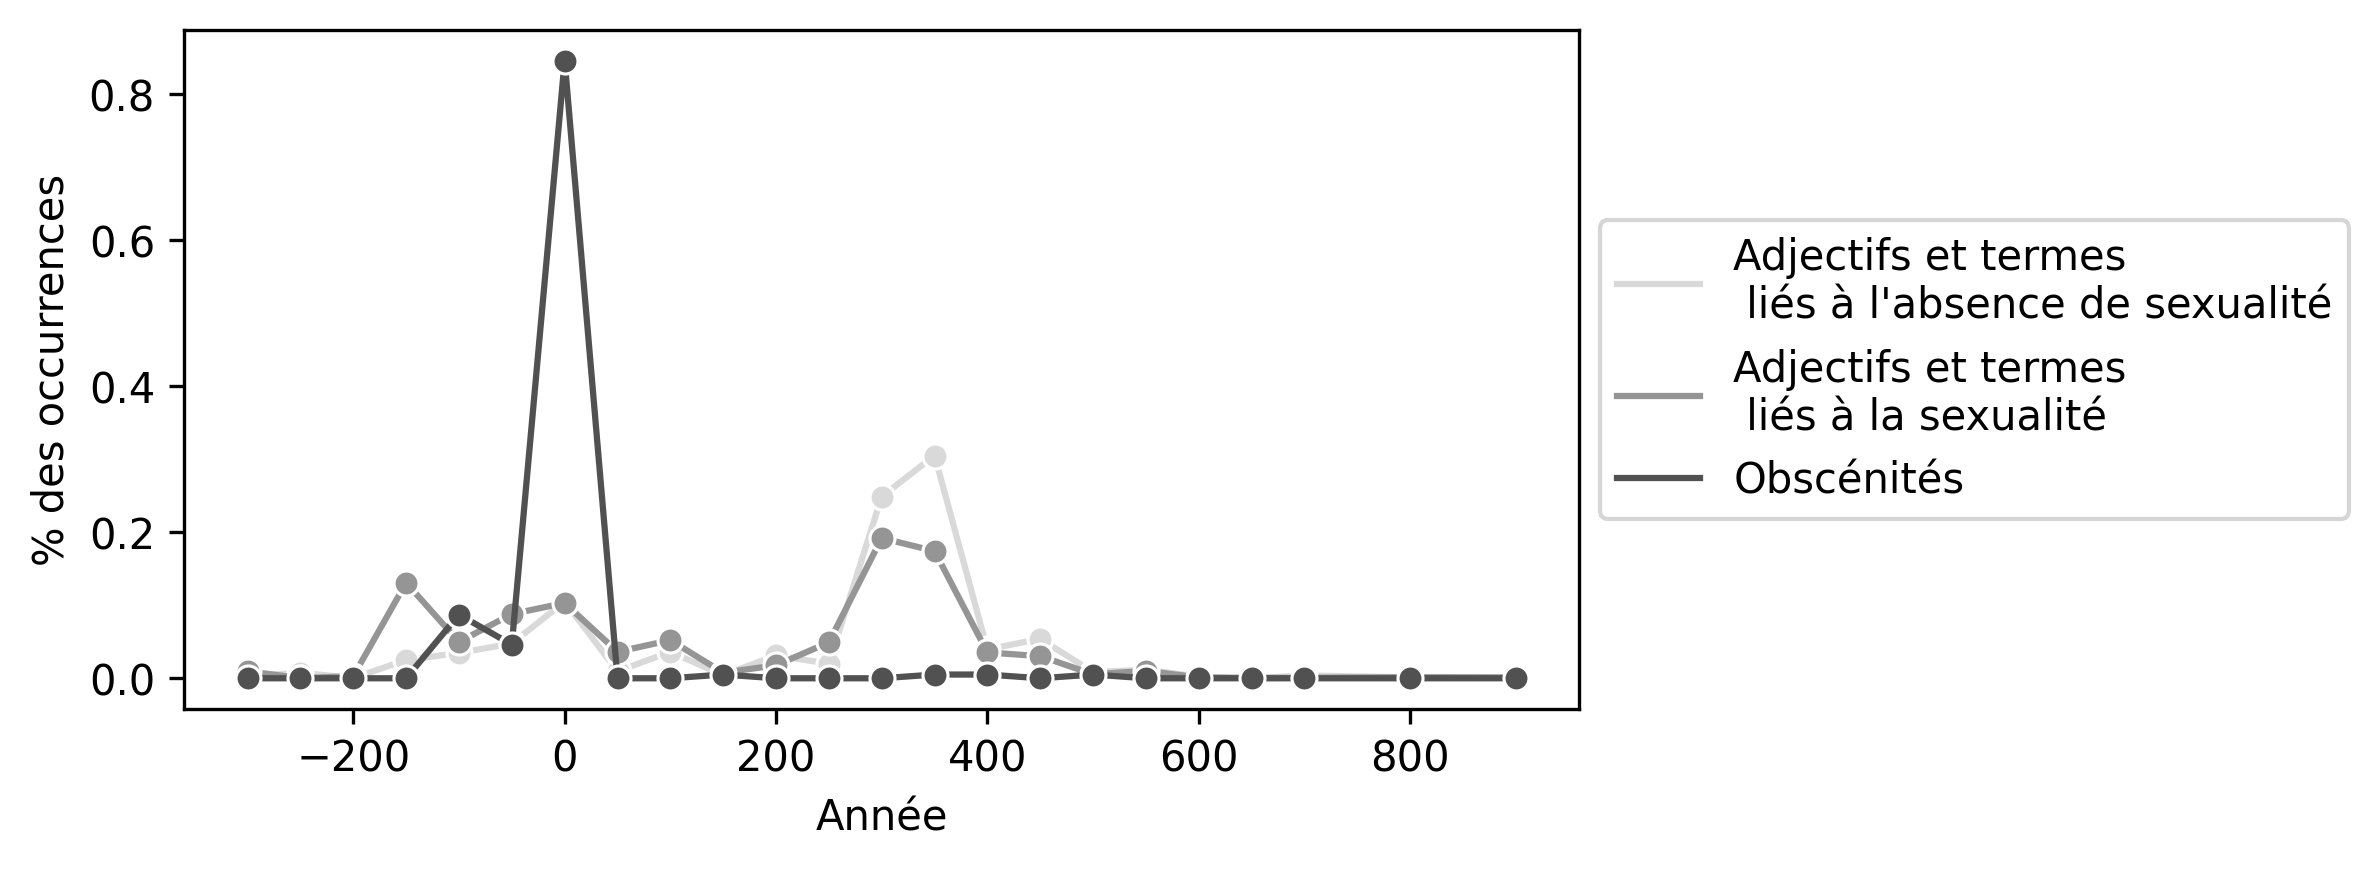

In [111]:
#fig, axs = plt.subplots(len(df[Key].unique()), 1, figsize=(6, 5), dpi=300)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)

#for i, (ax, (cur_word, _)) in enumerate(zip(axs, WORDS)):
#    sns.lineplot(
#        data=df[df["Lemmes et lexèmes"] == cur_word], 
#        x="Année", y="Fréquence relative",
#        ax=ax,
#        marker="o"
#    )
#    ax.get_xaxis().set_visible(False)
#    ax.set_ylim([0.00, .5])
#    ax.set_ylabel(cur_word,rotation=0)

 
sns.lineplot(
    data=df, 
    x="Année", 
    y="Fréquence relative",
    hue=Key,
    ax=ax,
    marker="o",
    palette="Greys"
)
ax.set_ylabel("% des occurrences")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

lasciv-
mollis & mollitia
virginitas
purus & puritas
impurus
libido
voluptas
mentula
futuo
pedico
irrumo
cunnus
